In [ ]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import archimedes as arc
from archimedes.experimental import coco as cc
from archimedes.experimental import lqr_design

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

In [3]:
# Dynamics function
system = CartPole()


def f(t, x, u, p):
    return system.dynamics(t, x, u)


# Running cost
def j(t, x, u, p):
    return u**2


# Total cost
def cost(x0, t0, xf, tf, q, p):
    return q


# Discretize the domain
N = [40]
knots = []
domain = cc.RadauFiniteElements(N=N, knots=knots)

t0, tf = 0.0, 2.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])
xf = np.array([1.0, np.pi, 0.0, 0.0])
boundary_conditions = [
    cc.start_time(t0),
    cc.end_time(tf),
    cc.initial_condition(x0),
    cc.final_condition(xf),
]


# Define the optimal control problem
ocp = cc.OptimalControlProblem(
    nx=4,
    nu=1,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=boundary_conditions,
)


# Linearly interpolate initial guess
def x_guess(t):
    return x0 + (t - t0) * (xf - x0) / (tf - t0)


# Initialize the problem
ocp_sol = ocp.solve(domain, t_guess=(t0, tf), x_guess=x_guess)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7170
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:      520

Total number of variables............................:      206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      170
Total number of inequality c

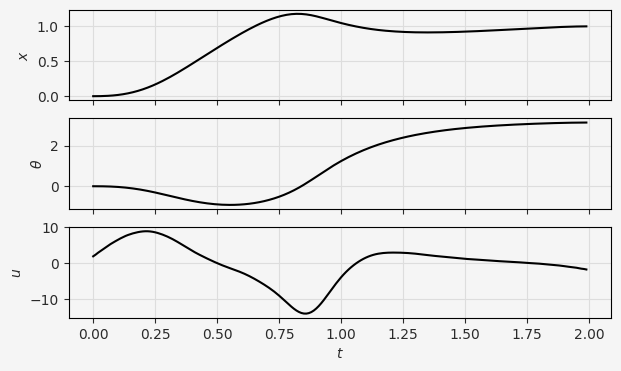

In [4]:
import matplotlib.pyplot as plt

dt = 0.01
ts = np.arange(t0, tf, dt)

x_opt = ocp_sol.x(ts)
u_opt = ocp_sol.u(ts)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, x_opt[:, 0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, x_opt[:, 1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].plot(ts, u_opt, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")

plt.show()

## Simulate optimal trajectory

In [5]:
def u_target(t):
    return np.stack([np.interp(t, ts, u_opt[:, i]) for i in range(u_opt.shape[1])])


def x_target(t):
    return np.stack([np.interp(t, ts, x_opt[:, i]) for i in range(x_opt.shape[1])])


@arc.compile
def f(t, x):
    return system.dynamics(t, x, u_target(t))


xs = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts).T

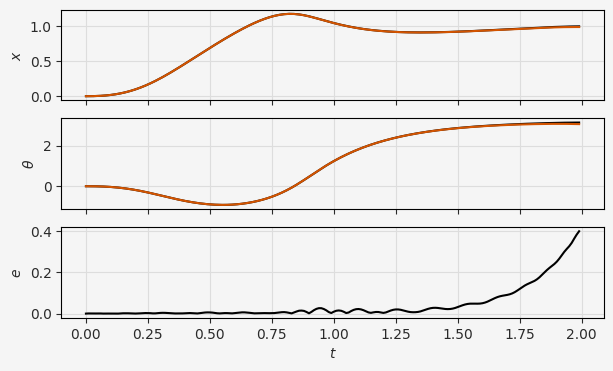

In [6]:
err = xs - x_opt
err = np.linalg.norm(err, axis=1)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
# ax[0].scatter(ocp_sol.tp, ocp_sol.xp[:, 0], c='k')
ax[0].plot(ts, x_opt[:, 0], c="k")
ax[0].plot(ts, xs[:, 0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
# ax[1].scatter(ocp_sol.tp, ocp_sol.xp[:, 1], c='k')
ax[1].plot(ts, x_opt[:, 1], c="k")
ax[1].plot(ts, xs[:, 1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
# ax[2].scatter(ocp_sol.tp[:-1], ocp_sol.up, c='k')
ax[2].plot(ts, err, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$e$")
ax[2].set_xlabel(r"$t$")

plt.show()

# LQR stabilization

In [7]:
Qf = np.diag(np.ones(nx))
Q = np.diag(np.ones(nx))
R = 1e-2 * np.diag(np.ones(nu))


u_lqr = lqr_design(
    system.dynamics,
    x0=x_target,
    u0=u_target,
    ts=ts,
    Qf=Qf,
    Q=Q,
    R=R,
)


@arc.compile
def lqr_rhs(t, x):
    u = u_target(t) + u_lqr(t, x)
    return system.dynamics(t, x, u)


xs = arc.odeint(lqr_rhs, t_span=(t0, tf), x0=x0, t_eval=ts).T

err_lqr = xs - x_opt
err_lqr = np.linalg.norm(err_lqr, axis=1)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, x_opt[:, 0], c="k")
ax[0].plot(ts, xs[:, 0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, x_opt[:, 1], c="k")
ax[1].plot(ts, xs[:, 1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].plot(ts, err, c="k")
ax[2].plot(ts, err_lqr)
ax[2].grid()
ax[2].set_ylabel(r"$e$")
ax[2].set_xlabel(r"$t$")

plt.show()

NameError: name 'nx' is not defined